# Clustering of Cell Types based on ATAC Signal

### Import Packages and Data Prep

In [134]:
import importlib
import functions
importlib.reload(functions)
functions.set_user('Pia')
data = functions.call_data_clean(p_threshold=1.3)

import pandas as pd
import seaborn as sns
import umap
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import scanpy as sc
import leidenalg
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform


ATAC_T = data['ATAC_seq_T']
ATAC_scores = data ['norm_scores']
QC = data['QC_metrics']
T_lineage = data['list_ATAC_Tc_all']

# df for UMAP dimension reduction and clustering
scores_t = ATAC_scores.T

scores_t.index.name = 'CellType'

#subset qc dataframe to add only lineage, cell family and organ information
QC_subset = QC[['CellType', 'Lineage', 'CellFamily', 'Organ']].drop_duplicates(subset='CellType', keep='first').reset_index(drop=True)

#merge ATAC dataframe with QC subset, drop duplicate Celltype rows from QC and reset index (combined)
ATAC_w_info = scores_t.merge(QC_subset, on='CellType', how='left').reset_index(drop=True)

#print NaN rows
ATAC_w_info[ATAC_w_info.isna().any(axis=1)]

,CellType,ImmGenATAC1219.peak_3,ImmGenATAC1219.peak_4,ImmGenATAC1219.peak_5,ImmGenATAC1219.peak_6,ImmGenATAC1219.peak_7,ImmGenATAC1219.peak_8,ImmGenATAC1219.peak_9,ImmGenATAC1219.peak_10,ImmGenATAC1219.peak_12,...,ImmGenATAC1219.peak_512587,ImmGenATAC1219.peak_512588,ImmGenATAC1219.peak_512589,ImmGenATAC1219.peak_512590,ImmGenATAC1219.peak_512591,ImmGenATAC1219.peak_512592,ImmGenATAC1219.peak_512595,Lineage,CellFamily,Organ
85,FRC.SLN,5.160862,3.071593,0.589547,0.368259,1.272359,1.291888,0.589547,0.084545,0.106768,...,1.242561,1.950112,1.931556,2.294698,2.309145,2.139871,0.552247,NaN,NaN,NaN


FRC.SLN not in QC metrics 

Added Lineage, Cell Family etc. in the following step

In [118]:
# add cell family, lineage and organ for FRC.SLN cells

ATAC_w_info.at[85, 'CellFamily'] = 'Fibroblastic reticular cell'
ATAC_w_info.at[85, 'Lineage'] = 'stroma'
ATAC_w_info.at[85, 'Organ'] = 'skin draining Lymph Node'

ATAC_w_info

,CellType,ImmGenATAC1219.peak_3,ImmGenATAC1219.peak_4,ImmGenATAC1219.peak_5,ImmGenATAC1219.peak_6,ImmGenATAC1219.peak_7,ImmGenATAC1219.peak_8,ImmGenATAC1219.peak_9,ImmGenATAC1219.peak_10,ImmGenATAC1219.peak_12,...,ImmGenATAC1219.peak_512587,ImmGenATAC1219.peak_512588,ImmGenATAC1219.peak_512589,ImmGenATAC1219.peak_512590,ImmGenATAC1219.peak_512591,ImmGenATAC1219.peak_512592,ImmGenATAC1219.peak_512595,Lineage,CellFamily,Organ
0,LTHSC.34-.BM,1.205769,0.295129,0.295129,1.205769,0.295129,1.205769,1.773756,2.285555,1.205769,...,0.295129,0.295129,0.295129,1.205769,1.773756,0.295129,0.295129,Stem&Prog,Stem&Prog Cell,Bone Marrow
1,LTHSC.34+.BM,0.074722,0.074722,0.074722,0.904419,0.074722,0.461970,0.074722,0.074722,0.074722,...,1.242548,2.690196,2.304221,2.504007,2.504007,2.304221,0.461970,Stem&Prog,Stem&Prog Cell,Bone Marrow
2,STHSC.150-.BM,0.560426,0.081366,0.081366,0.982424,0.081366,0.560426,0.560426,0.081366,0.081366,...,1.274315,1.514311,0.982424,0.560426,1.514311,1.514311,0.560426,Stem&Prog,Stem&Prog Cell,Bone Marrow
3,MPP4.135+.BM,0.080439,0.080439,0.080439,0.866791,0.080439,0.080439,0.080439,0.080439,0.518688,...,1.229507,1.084557,1.495297,1.084557,1.229507,1.369970,1.495297,Stem&Prog,Stem&Prog Cell,Bone Marrow
4,proB.CLP.BM,0.317339,0.499312,0.317339,0.665651,0.080769,0.865400,0.286711,0.317339,1.011158,...,1.764466,1.329309,2.005463,1.433638,1.679784,2.131459,1.317237,B,B Cell,Bone Marrow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,FRC.SLN,5.160862,3.071593,0.589547,0.368259,1.272359,1.291888,0.589547,0.084545,0.106768,...,1.242561,1.950112,1.931556,2.294698,2.309145,2.139871,0.552247,stroma,Fibroblastic reticular cell,skin draining Lymph Node
86,IAP.SLN,2.528480,0.607880,0.486492,0.806198,0.486492,0.607880,0.341822,0.486492,0.341822,...,1.250693,1.994107,2.556288,1.540485,2.065877,2.505569,0.792902,stroma,Pericyte,skin draining Lymph Node
87,BEC.SLN,0.801883,0.778569,0.801883,0.587879,1.192532,0.801883,1.051819,1.291382,1.323956,...,1.671479,1.473731,1.160424,1.307761,1.959644,2.268279,0.398995,stroma,Blood endothelial cell,skin draining Lymph Node
88,LEC.SLN,0.670699,0.670699,0.938263,1.396850,1.221350,2.364179,1.053502,1.203636,0.087597,...,2.127289,2.458313,2.237593,2.063903,2.237593,2.493728,0.087597,stroma,Lymphatic endothelial cell,skin draining Lymph Node


## UMAP of Cell Types

### Dimension Reduction

In [119]:
# umap embedding
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)

# just use numeric data for UMAP
numeric_data = ATAC_w_info.select_dtypes(include=['number']).dropna()

# exclude metadata columns for embedding
umap_embedding = umap_model.fit_transform(numeric_data)  

# Create a DataFrame for the UMAP embedding
umap_df = pd.DataFrame(umap_embedding, columns=['UMAP1', 'UMAP2'])

#metadata columns
celltype = ATAC_w_info['CellType']
lineage = ATAC_w_info['Lineage']
cellfamily = ATAC_w_info['CellFamily']
organ = ATAC_w_info['Organ']

# Add metadata columns to the UMAP DataFrame
umap_df['CellType'] = celltype
umap_df['Lineage'] = lineage
umap_df['CellFamily'] = cellfamily
umap_df['Organ'] = organ

umap_df


/opt/miniconda3/envs/dataanalysisenv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


,UMAP1,UMAP2,CellType,Lineage,CellFamily,Organ
0,0.220429,9.455475,LTHSC.34-.BM,Stem&Prog,Stem&Prog Cell,Bone Marrow
1,0.247965,9.497551,LTHSC.34+.BM,Stem&Prog,Stem&Prog Cell,Bone Marrow
2,-0.056808,9.558232,STHSC.150-.BM,Stem&Prog,Stem&Prog Cell,Bone Marrow
3,-0.110163,9.604287,MPP4.135+.BM,Stem&Prog,Stem&Prog Cell,Bone Marrow
4,-0.290898,9.378751,proB.CLP.BM,B,B Cell,Bone Marrow
...,...,...,...,...,...,...
85,1.819733,10.979116,FRC.SLN,stroma,Fibroblastic reticular cell,skin draining Lymph Node
86,10.790327,-0.455066,IAP.SLN,stroma,Pericyte,skin draining Lymph Node
87,1.603154,11.313616,BEC.SLN,stroma,Blood endothelial cell,skin draining Lymph Node
88,1.756253,11.049805,LEC.SLN,stroma,Lymphatic endothelial cell,skin draining Lymph Node


###  UMAP colored by Cell Lineage

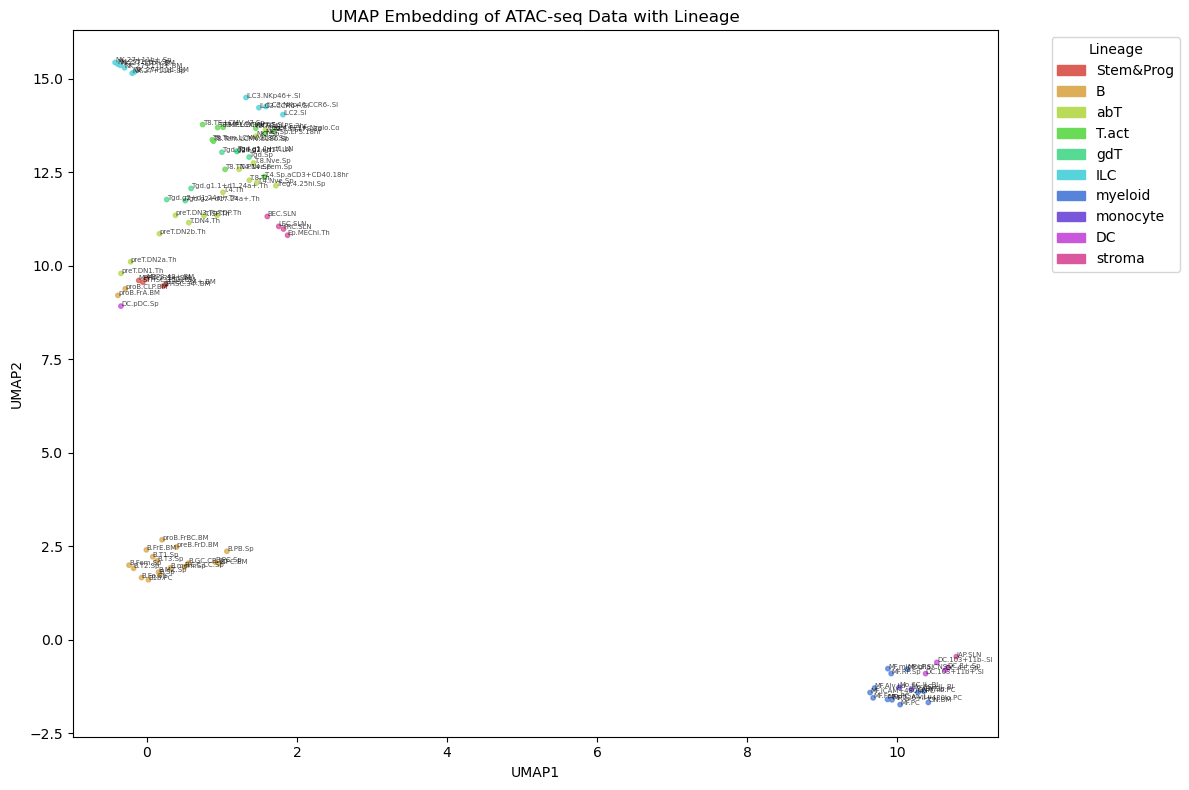

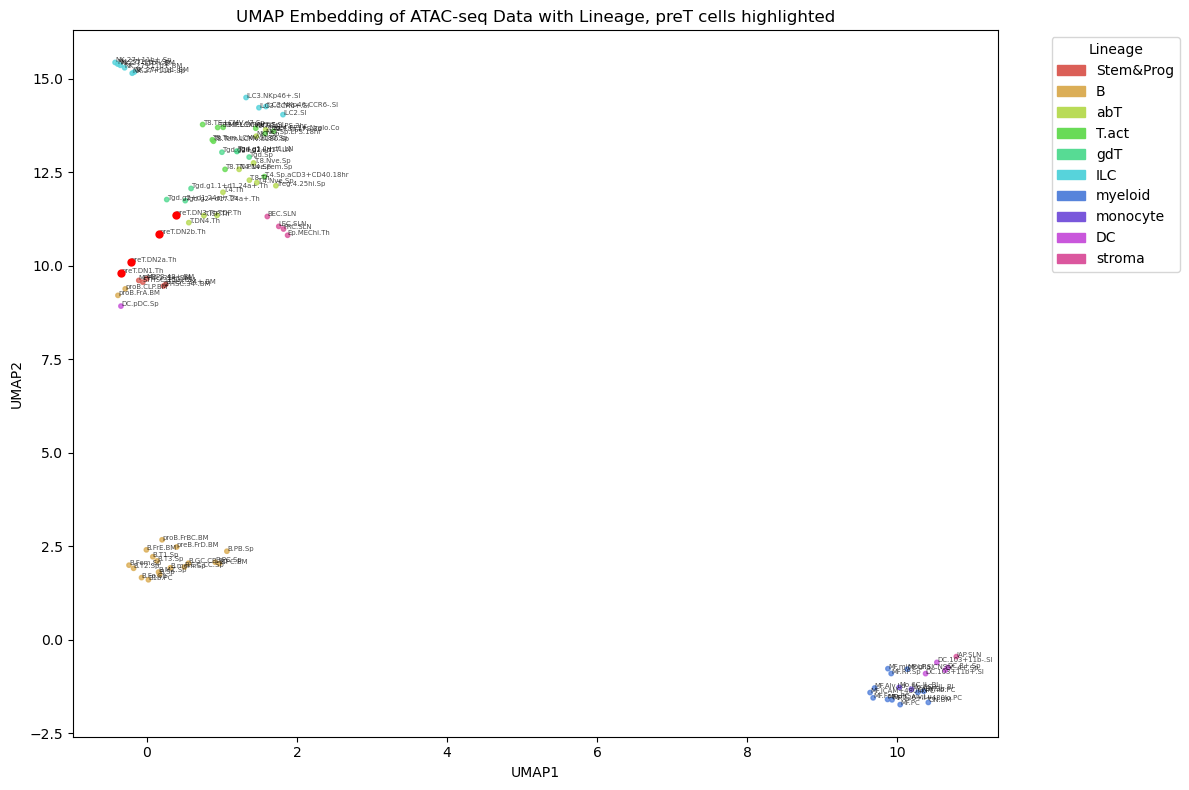

In [120]:
# assign colors to lineages
unique_lineages = umap_df['Lineage'].unique()
lin_palette = sns.color_palette("hls", len(unique_lineages))
lin_color_dict = dict(zip(unique_lineages, lin_palette))
lin_point_colors = umap_df['Lineage'].map(lin_color_dict)

# Plot UMAP embedding
plt.figure(figsize=(12, 8))
plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'], c=lin_point_colors, s=10 , alpha=0.8)

#Add cell type labels
for i, row in umap_df.iterrows():
    plt.text(row['UMAP1'], row['UMAP2'], str(row['CellType']), fontsize=5, alpha=0.7)

plt.title('UMAP Embedding of ATAC-seq Data with Lineage')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
lin_handles = [
    mpatches.Patch(color=lin_color_dict[lin], label=lin)
    for lin in unique_lineages
    ]
plt.legend(handles=lin_handles, title="Lineage", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Get unique lineages and assign colors
unique_lineages = umap_df['Lineage'].unique()
lin_palette = sns.color_palette("hls", len(unique_lineages))
lin_color_dict = dict(zip(unique_lineages, lin_palette))
lin_point_colors = umap_df['Lineage'].map(lin_color_dict)

# Define cells to highlight
preT_cells = ['preT.DN1.Th', 'preT.DN2a.Th', 'preT.DN2b.Th', 'preT.DN3.Th']
highlight_df = umap_df[umap_df['CellType'].isin(preT_cells)]

# Plotting the UMAP embedding
plt.figure(figsize=(12, 8))
plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'], c=lin_point_colors, s=10 , alpha=0.8)

#Add cell type labels
for i, row in umap_df.iterrows():
    plt.text(row['UMAP1'], row['UMAP2'], str(row['CellType']), fontsize=5, alpha=0.7)

plt.title('UMAP Embedding of ATAC-seq Data with Lineage, preT cells highlighted')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
lin_handles = [
    mpatches.Patch(color=lin_color_dict[lin], label=lin)
    for lin in unique_lineages
    ]
# Overlay highlighted cells
plt.scatter(
    highlight_df['UMAP1'], highlight_df['UMAP2'],
    color='red',
    s=20,          
    linewidth=1.5,
    label='preT-Cell Differentiation',
    zorder=5
)
plt.legend(handles=lin_handles, title="Lineage", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Highlighted: differentiation states of double negative pre T cells (preT.DNXy.Th). Further in differentiation => closer to differentiated T cells

### Kmeans Clustering

k = 2, silhouette score = 0.715
k = 3, silhouette score = 0.829
k = 4, silhouette score = 0.685
k = 5, silhouette score = 0.678
k = 6, silhouette score = 0.725
k = 7, silhouette score = 0.696
k = 8, silhouette score = 0.601
k = 9, silhouette score = 0.477
k = 10, silhouette score = 0.505


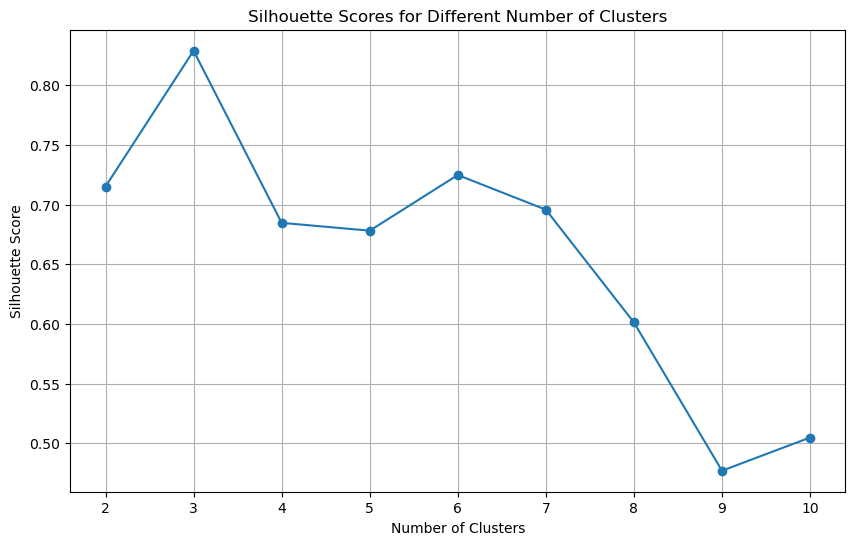

In [121]:
# silhouette score to determine optimal number of clusters
kmeans_df = umap_df[['UMAP1', 'UMAP2']].copy()

max_clusters=10 

silhouette_scores = []

# Calculate silhouette scores for different numbers of clusters

for n_clusters in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(kmeans_df)
    score = silhouette_score(kmeans_df, cluster_labels)
    silhouette_scores.append(score)
    print(f"k = {n_clusters}, silhouette score = {score:.3f}")
 
# plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, len(silhouette_scores) + 2), silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, len(silhouette_scores) + 2))
plt.grid()
plt.show()


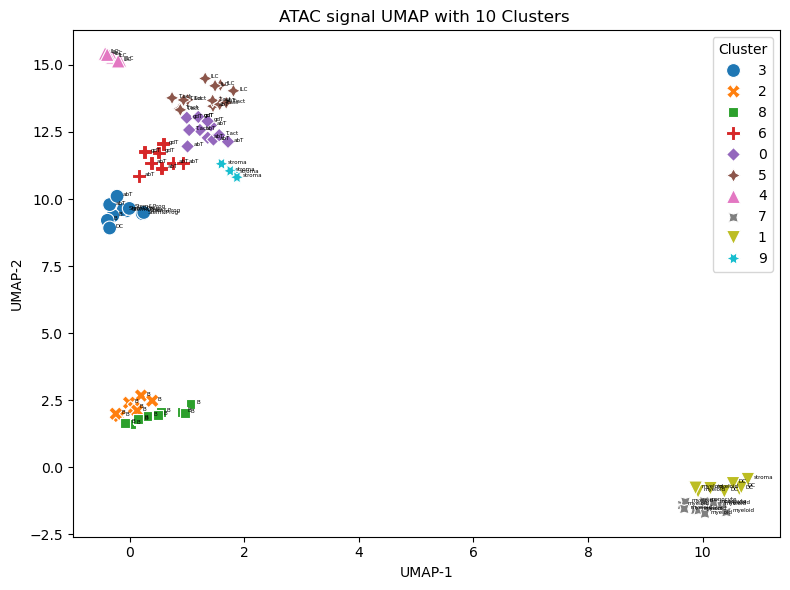

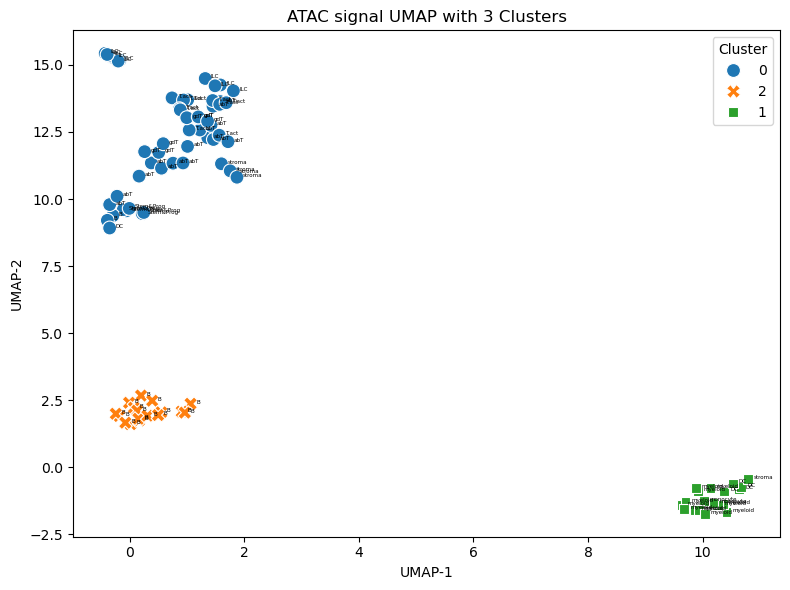

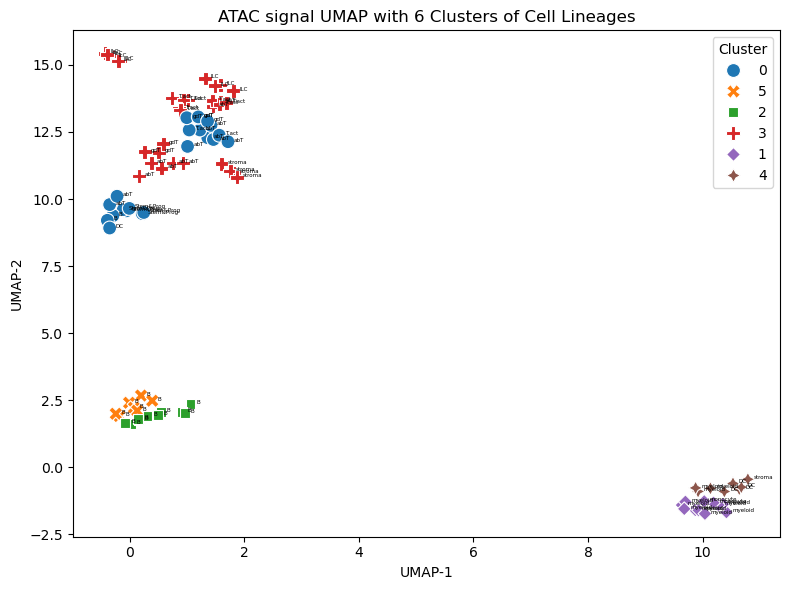

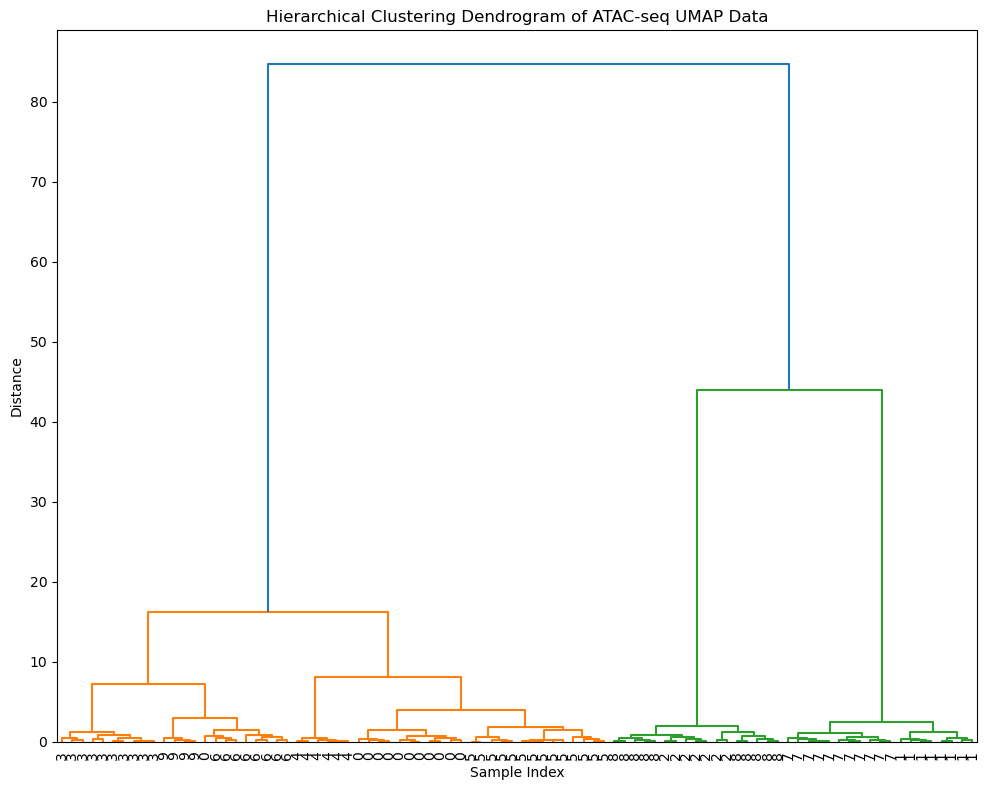

In [122]:
# kmeans with 10 clusters to compare to lineage-based grouping
kmeans10 = KMeans(n_clusters=10, random_state=42)
kmeans_df["kmeans10"] = kmeans10.fit_predict(kmeans_df).astype(str)

# kmeans with 3 clusters (optimal number of clusters)
kmeans3 = KMeans(n_clusters=3, random_state=42)
kmeans_df["kmeans3"] = kmeans3.fit_predict(kmeans_df).astype(str)

# kmeans with 6 clusters (for comparison)
kmeans6 = KMeans(n_clusters=6, random_state=42)
kmeans_df["kmeans6"] = kmeans6.fit_predict(kmeans_df).astype(str)


# plot clusterings and dendrograms

# 10 clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=kmeans_df, x="UMAP1", y="UMAP2", hue="kmeans10", style="kmeans10", s=100, palette="tab10")

for i, row in umap_df.iterrows():
    plt.text(row["UMAP1"] + 0.1, row["UMAP2"], row["Lineage"], fontsize=4)

plt.title("ATAC signal UMAP with 10 Clusters ")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


# 3 clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=kmeans_df, x="UMAP1", y="UMAP2", hue="kmeans3", style="kmeans3", s=100, palette="tab10")

for i, row in umap_df.iterrows():
    plt.text(row["UMAP1"] + 0.1, row["UMAP2"], row["Lineage"], fontsize=4)

plt.title("ATAC signal UMAP with 3 Clusters")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

# 6 clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=kmeans_df, x="UMAP1", y="UMAP2", hue="kmeans6", style="kmeans6", s=100, palette="tab10")

for i, row in umap_df.iterrows():
    plt.text(row["UMAP1"] + 0.1, row["UMAP2"], row["Lineage"], fontsize=4)

plt.title("ATAC signal UMAP with 6 Clusters of Cell Lineages")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

# dendrogram
plt.figure(figsize=(10, 8))
Z = linkage(kmeans_df[['UMAP1', 'UMAP2']], method='ward')
dendrogram(Z, labels=kmeans_df['kmeans10'].values, leaf_rotation=90, leaf_font_size=10)
plt.title("Hierarchical Clustering Dendrogram of ATAC-seq UMAP Data")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

### Leiden Clustering

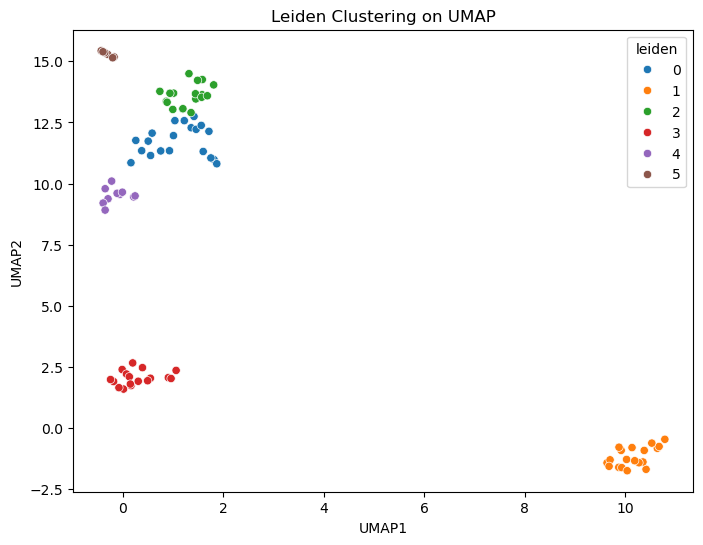

In [123]:
leiden_df = umap_df[["UMAP1", "UMAP2"]].values

# Create AnnData object of UMAP coordinates
adata = sc.AnnData(X=leiden_df)
adata.obs["CellType"] = umap_df["CellType"].values 

# Perform Leiden clustering
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X')
sc.tl.leiden(adata, resolution=1.0, key_added="leiden")

# visualize clusters
adata_df = pd.DataFrame(adata.X, columns=["UMAP1", "UMAP2"])
adata_df["leiden"] = adata.obs["leiden"].values

plt.figure(figsize=(8, 6))
sns.scatterplot(data=adata_df, x="UMAP1", y="UMAP2", hue="leiden", palette="tab10")
plt.title("Leiden Clustering on UMAP")
plt.show()



## Correlation of clusterings and cell lineages

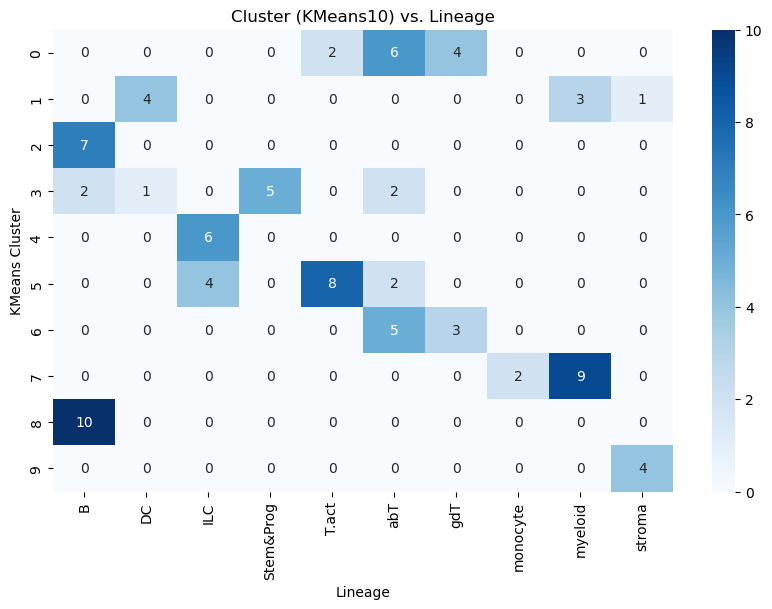

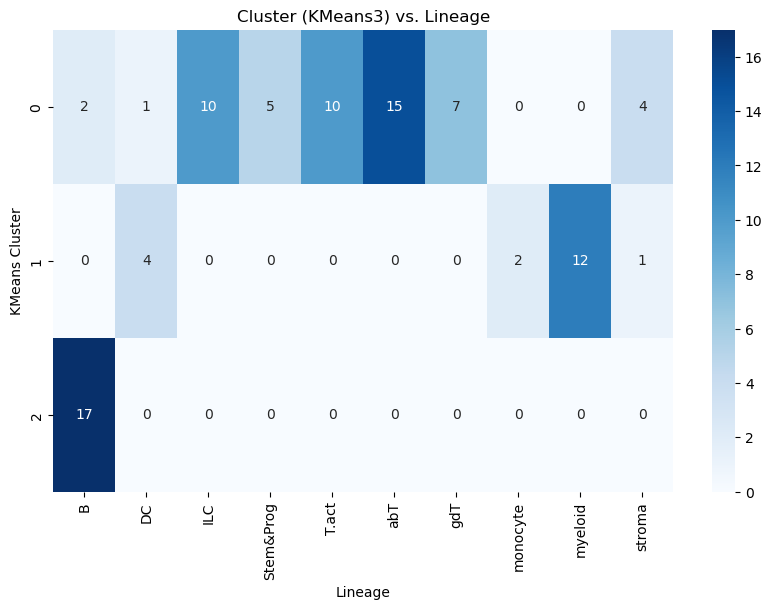

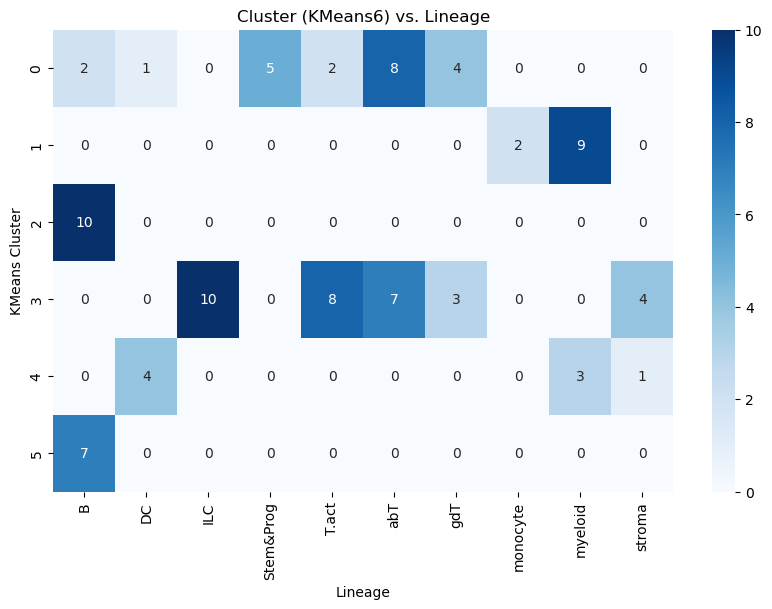

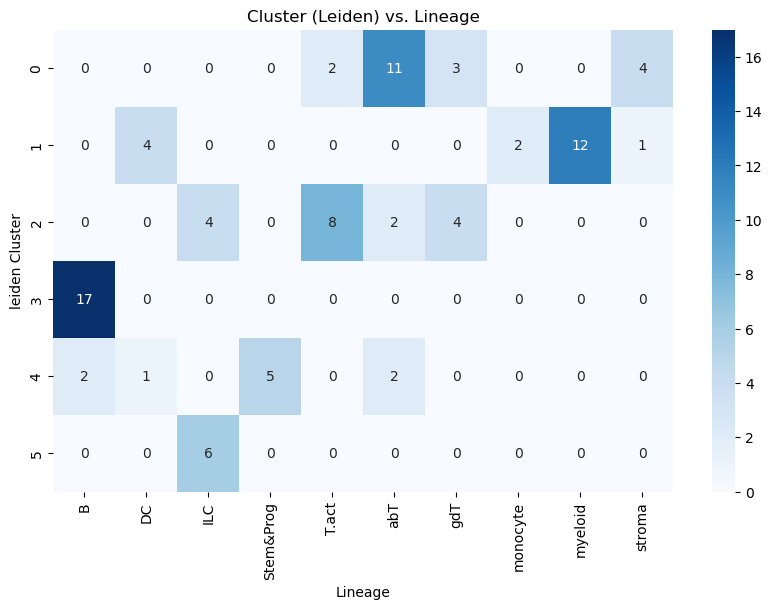

ARI kmeans10 = 0.423
NMI kmeans10 = 0.694
ARI kmeans3 = 0.257
NMI kmeans3 = 0.531
ARI kmeans6 = 0.270
NMI kmeans6 = 0.569
ARI leiden = 0.501
NMI leiden = 0.664


In [124]:
# add clusters to umap_df
umap_df["kmeans10"] = kmeans_df["kmeans10"]
umap_df["kmeans3"] = kmeans_df["kmeans3"]
umap_df["kmeans6"] = kmeans_df["kmeans6"]
umap_df["leiden"] = adata.obs["leiden"].values

# contingency table
contingency_kmeans10 = pd.crosstab(umap_df["kmeans10"], umap_df["Lineage"])
contingency_kmeans3 = pd.crosstab(umap_df["kmeans3"], umap_df["Lineage"])
contingency_kmeans6 = pd.crosstab(umap_df["kmeans6"], umap_df["Lineage"])
contingency_leiden = pd.crosstab(umap_df["leiden"], umap_df['Lineage'])


# Visualisierung als Heatmap
#kmeans 10
plt.figure(figsize=(10, 6))
sns.heatmap(contingency_kmeans10, annot=True, fmt="d", cmap="Blues")
plt.title("Cluster (KMeans10) vs. Lineage")
plt.xlabel("Lineage")
plt.ylabel("KMeans Cluster")
plt.show()
#kmeans 3
plt.figure(figsize=(10, 6))
sns.heatmap(contingency_kmeans3, annot=True, fmt="d", cmap="Blues")
plt.title("Cluster (KMeans3) vs. Lineage")
plt.xlabel("Lineage")
plt.ylabel("KMeans Cluster")
plt.show()
#kmeans 6
plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab(umap_df["kmeans6"], umap_df["Lineage"]), annot=True, fmt="d", cmap="Blues")
plt.title("Cluster (KMeans6) vs. Lineage")
plt.xlabel("Lineage")
plt.ylabel("KMeans Cluster")
plt.show()
#leiden
plt.figure(figsize=(10, 6))
sns.heatmap(contingency_leiden, annot=True, fmt="d", cmap="Blues")
plt.title("Cluster (Leiden) vs. Lineage")
plt.xlabel("Lineage")
plt.ylabel("leiden Cluster")
plt.show()

# compare kmeans and leiden clusters to lineage

ari_kmeans10 = adjusted_rand_score(umap_df["Lineage"], umap_df["kmeans10"])
nmi_kmeans10 = normalized_mutual_info_score(umap_df["Lineage"], umap_df["kmeans10"])

ari_kmeans3 = adjusted_rand_score(umap_df["Lineage"], umap_df["kmeans3"])
nmi_kmeans3 = normalized_mutual_info_score(umap_df["Lineage"], umap_df["kmeans3"])

ari_kmeans6 = adjusted_rand_score(umap_df["Lineage"], umap_df["kmeans6"])
nmi_kmeans6 = normalized_mutual_info_score(umap_df["Lineage"], umap_df["kmeans6"])

ari_leiden = adjusted_rand_score(umap_df["Lineage"], adata.obs["leiden"])
nmi_leiden = normalized_mutual_info_score(umap_df["Lineage"], adata.obs["leiden"])


print(f"ARI kmeans10 = {ari_kmeans10:.3f}")
print(f"NMI kmeans10 = {nmi_kmeans10:.3f}")

print(f"ARI kmeans3 = {ari_kmeans3:.3f}")
print(f"NMI kmeans3 = {nmi_kmeans3:.3f}")

print(f"ARI kmeans6 = {ari_kmeans6:.3f}")
print(f"NMI kmeans6 = {nmi_kmeans6:.3f}")

print(f"ARI leiden = {ari_leiden:.3f}")
print(f"NMI leiden = {nmi_leiden:.3f}")

In [125]:
# calculate ARI and NMI means
ari_mean = np.mean([ari_kmeans10, ari_kmeans3, ari_kmeans6, ari_leiden])
nmi_mean = np.mean([nmi_kmeans10, nmi_kmeans3, nmi_kmeans6, nmi_leiden])
print(f"Mean ARI = {ari_mean:.3f}")
print(f"Mean NMI = {nmi_mean:.3f}")

ari_mean_no_3 = np.mean([ari_kmeans10, ari_kmeans6, ari_leiden])
nmi_mean_no_3 = np.mean([nmi_kmeans10, nmi_kmeans6, nmi_leiden])
print(f"Mean ARI without kmeans3 = {ari_mean_no_3:.3f}")
print(f"Mean NMI without kmeans3 = {nmi_mean_no_3:.3f}")

Mean ARI = 0.363
Mean NMI = 0.614
Mean ARI without kmeans3 = 0.398
Mean NMI without kmeans3 = 0.642


Information of Clusterings (for higher k) comparable to lineage-based grouping. 

## Mean ATAC profile per Cell Type

### Correlation between Cell Types

/var/folders/bb/wtz1qdn10sz99v6ltwmxxx0c0000gn/T/ipykernel_19499/2891104419.py:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(1 - cor_matrix_sp, method='average')


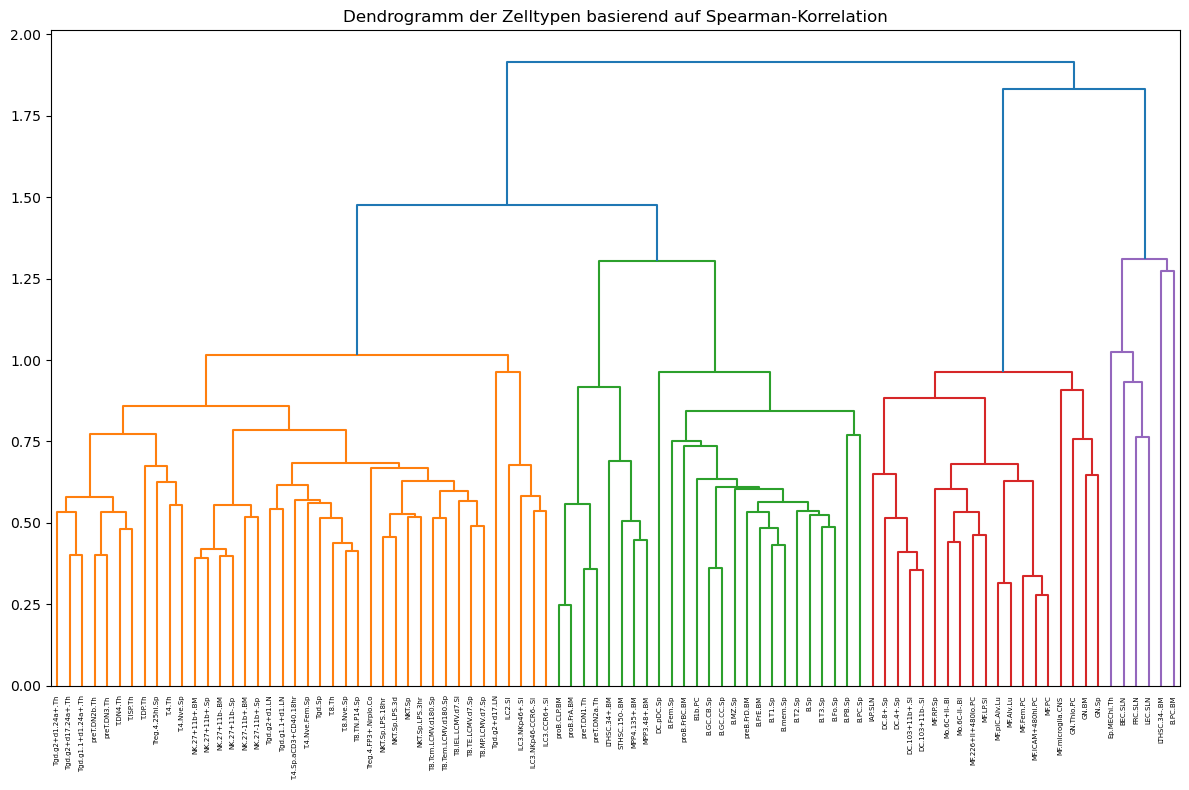

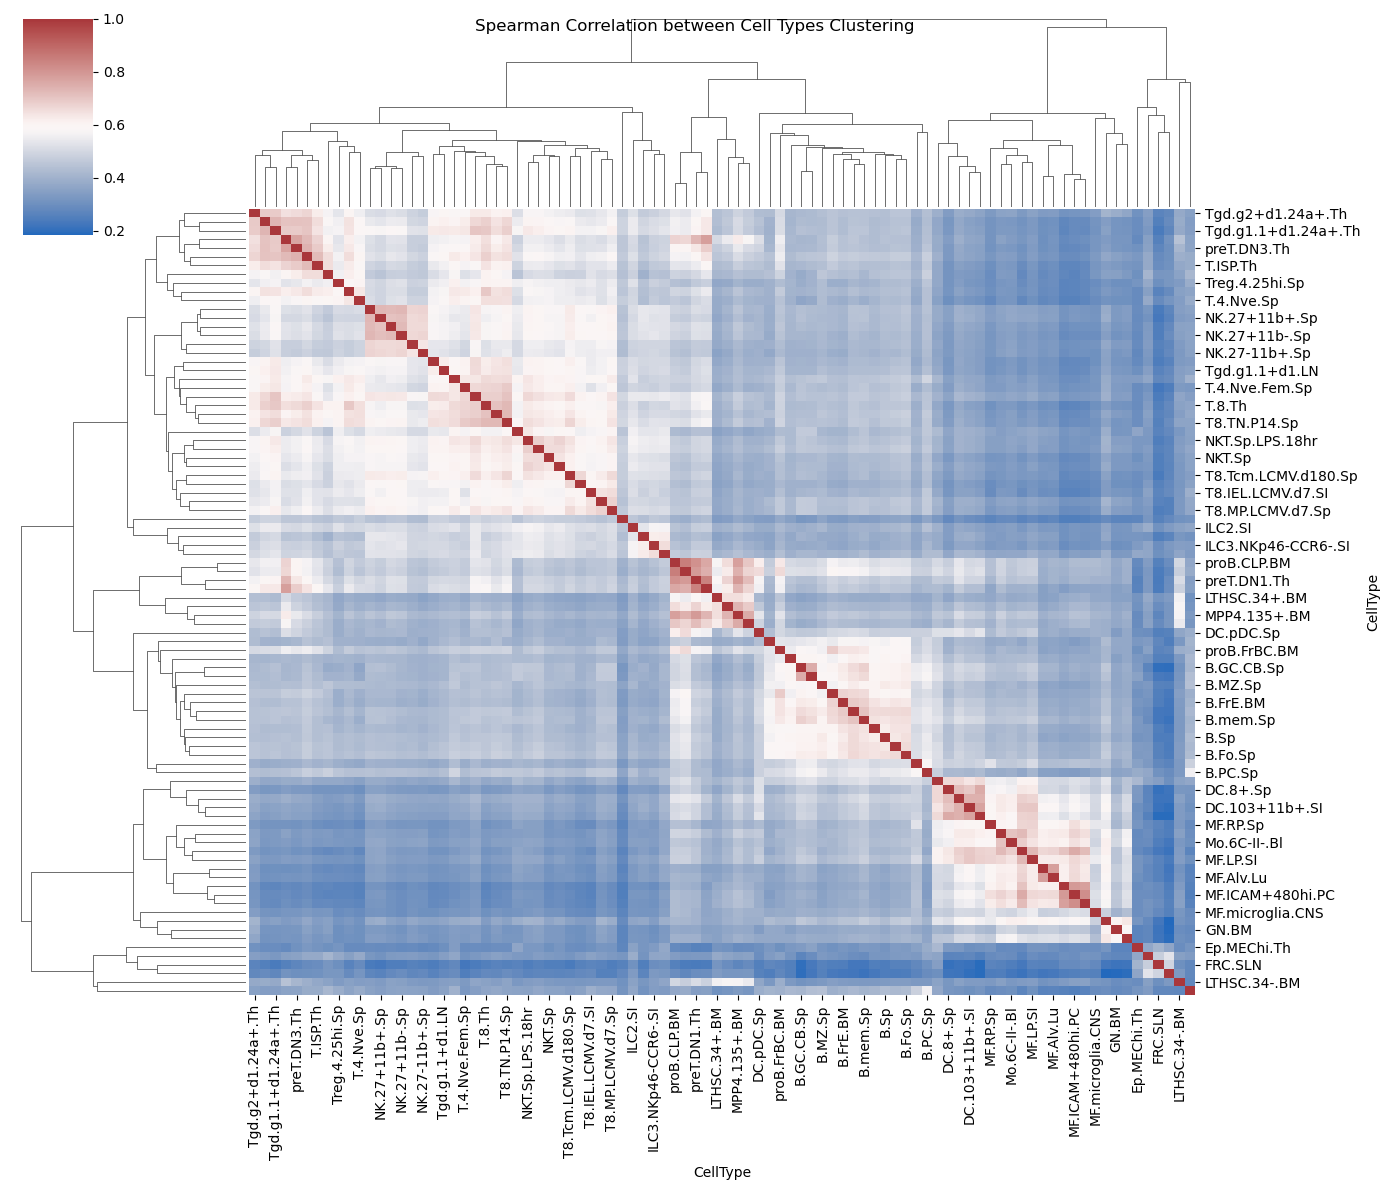

In [136]:
cor_matrix_sp = scores_t.T.corr(method='spearman')

# Dendrogramm der Zelltypen
plt.figure(figsize=(12, 8))
linkage_matrix = linkage(1 - cor_matrix_sp, method='average')
dendrogram(linkage_matrix, labels=cor_matrix_sp.index, leaf_rotation=90)
plt.title("Dendrogramm der Zelltypen basierend auf Spearman-Korrelation")
plt.tight_layout()
plt.show()

# Heatmap der Korrelationsmatrix (sorted by Cluster)
sns.clustermap(cor_matrix_sp, cmap="vlag", figsize=(14, 12))
plt.suptitle("Spearman Correlation between Cell Types Clustering")
plt.show()


#### Color by Cell Lineage

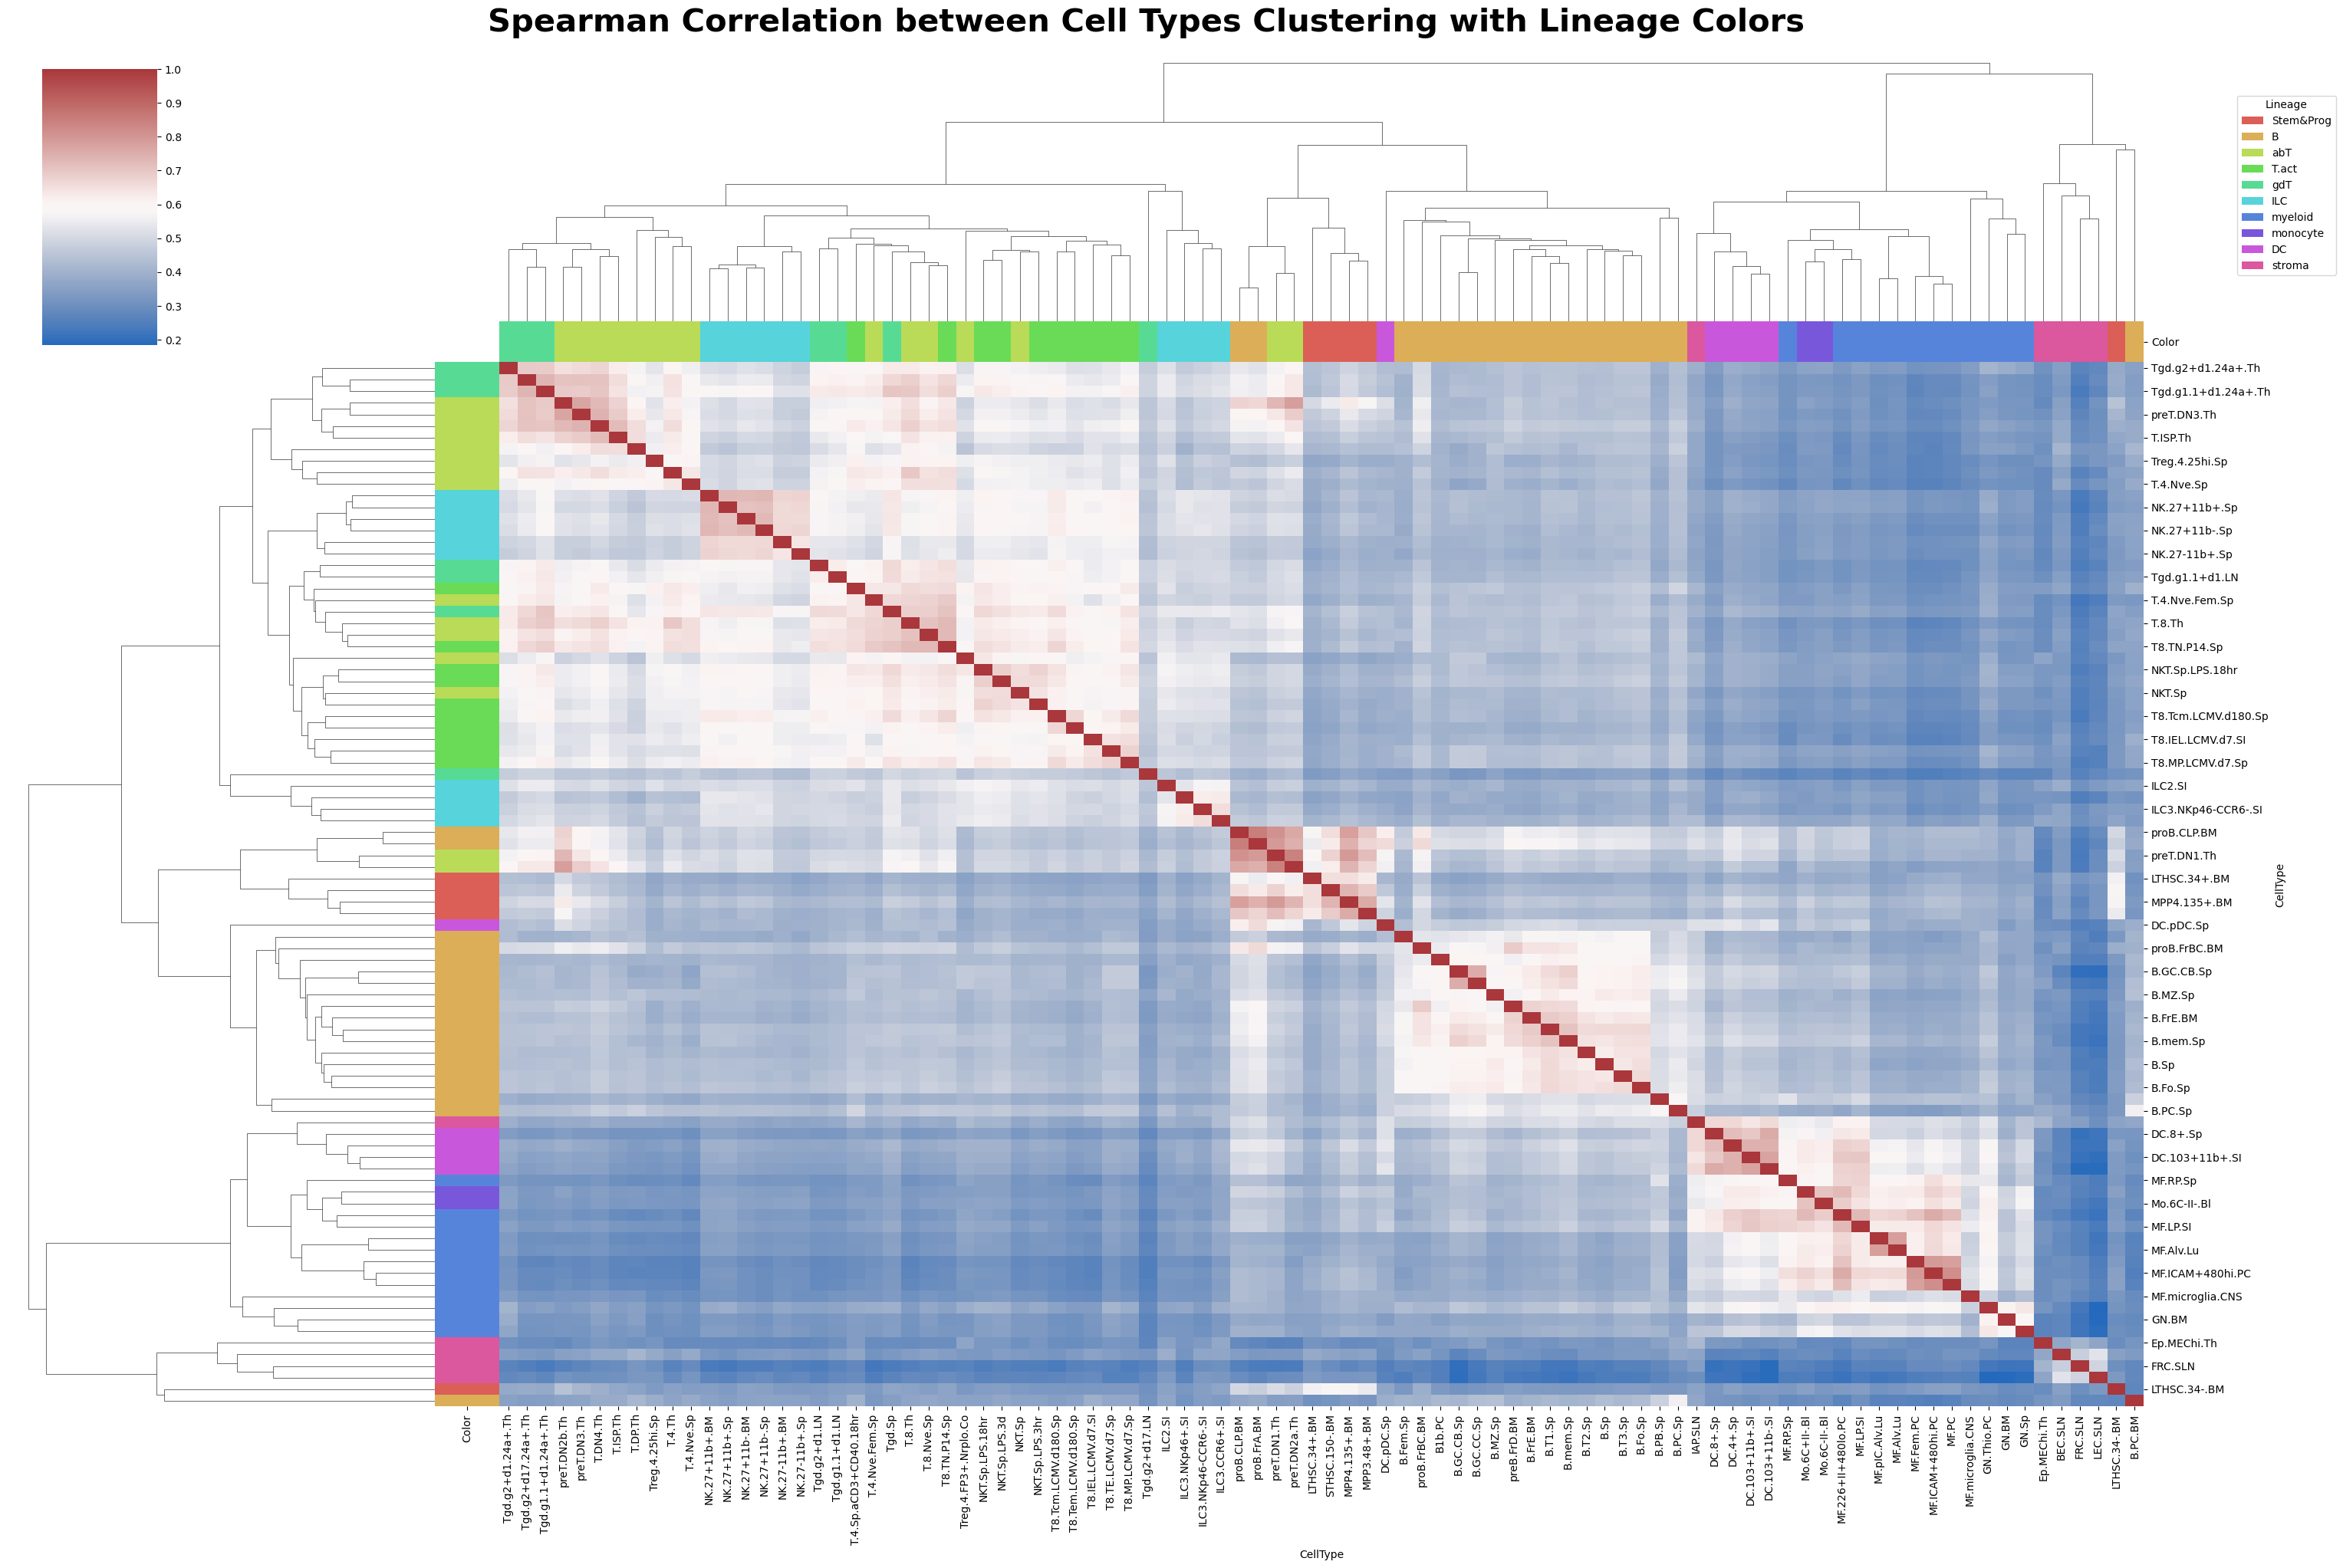

In [131]:
# Map colors to cell types
lineage_df['Color'] = lineage_df['Lineage'].map(lin_color_dict)

# Reorder to match the order in the correlation matrix
row_colors = lineage_df.loc[cor_matrix_sp.index, 'Color']

g = sns.clustermap(cor_matrix_sp, cmap="vlag", figsize=(30, 20),
               row_colors=row_colors, col_colors=row_colors)
plt.suptitle("Spearman Correlation between Cell Types Clustering with Lineage Colors", fontsize=30, fontweight='bold', y=1.02)

for label in lin_color_dict:
    g.ax_col_dendrogram.bar(0, 0, color=lin_color_dict[label],
                            label=label, linewidth=0)

g.ax_col_dendrogram.legend(title='Lineage', loc="center right", bbox_to_anchor=(1.12, 0.5), ncol=1)


# Save plot as png
g.savefig("celltype_clustermap.png", dpi=300)


In [ ]:
# linkage matrix (if not done)
dist_matrix = 1 - cor_matrix_sp  # distance = 1 - spearman correlation
# linkage needs condensed distance matrix, so flatten:
condensed_dist = squareform(dist_matrix.values)
linkage_matrix = linkage(condensed_dist, method='average')

# 2. Determine optimal number of clusters using silhouette score
sil_scores = []
range_n_clusters = range(2, 11)  # try 2 to 10 clusters

for n_clusters in range_n_clusters:
    cluster_labels = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')
    score = silhouette_score(dist_matrix, cluster_labels, metric='precomputed')
    sil_scores.append(score)

# Optional: print silhouette scores per cluster number
for n, score in zip(range_n_clusters, sil_scores):
    print(f"Clusters: {n}, Silhouette score: {score:.3f}")

# 3. Choose optimal number of clusters as the one with max silhouette score
optimal_clusters = range_n_clusters[np.argmax(sil_scores)]
print(f"Optimal number of clusters: {optimal_clusters}")

# 4. Assign cluster labels using the optimal number
cluster_labels_opt = fcluster(linkage_matrix, t=optimal_clusters, criterion='maxclust')

# 5. Create DataFrame mapping CellType to Cluster
cluster_df = pd.DataFrame({
    'CellType': cor_matrix_sp.index,
    'Cluster': cluster_labels_opt
}).set_index('CellType')

print(cluster_df.sort_values('Cluster'))


Clusters: 2, Silhouette score: 0.226
Clusters: 3, Silhouette score: 0.223
Clusters: 4, Silhouette score: 0.204
Clusters: 5, Silhouette score: 0.201
Clusters: 6, Silhouette score: 0.210
Clusters: 7, Silhouette score: 0.235
Clusters: 8, Silhouette score: 0.220
Clusters: 9, Silhouette score: 0.216
Clusters: 10, Silhouette score: 0.197
Optimal number of clusters: 7
                Cluster
CellType               
LEC.SLN               1
BEC.SLN               1
FRC.SLN               1
Ep.MEChi.Th           2
DC.103+11b-.SI        3
...                 ...
preT.DN1.Th           6
MPP3.48+.BM           6
proB.FrA.BM           6
LTHSC.34-.BM          6
B.PC.BM               7

[90 rows x 1 columns]


### Visualize lineage and clustering

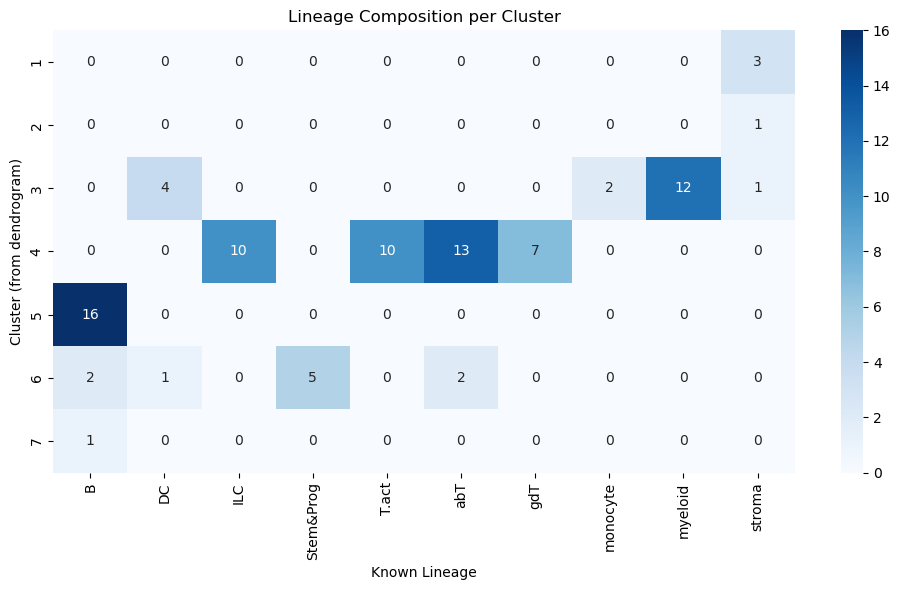

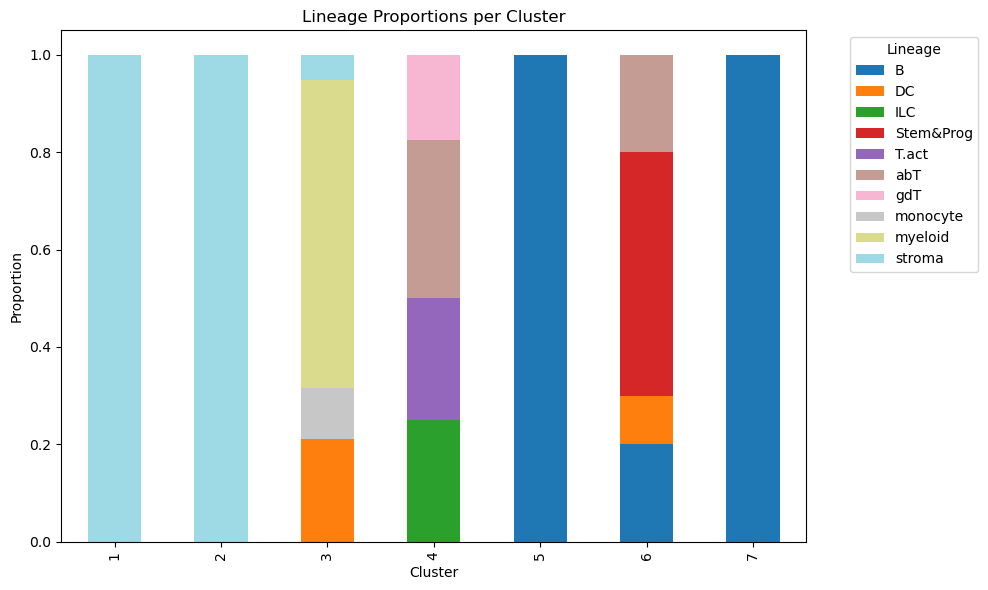

In [145]:
# Make sure you have both cluster and lineage info
comparison_df = cluster_df.join(lineage_df[['Lineage']])

# Crosstab: counts of Lineages per Cluster
confusion = pd.crosstab(comparison_df['Cluster'], comparison_df['Lineage'])

plt.figure(figsize=(10, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.title("Lineage Composition per Cluster")
plt.ylabel("Cluster (from dendrogram)")
plt.xlabel("Known Lineage")
plt.tight_layout()
plt.show()

# Normalize counts within each cluster
prop_df = confusion.div(confusion.sum(axis=1), axis=0)

# Stacked barplot
prop_df.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')
plt.title("Lineage Proportions per Cluster")
plt.ylabel("Proportion")
plt.xlabel("Cluster")
plt.legend(title='Lineage', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Cell Types of one lineage mostly cluster together